### Basic Linear Regression Modeling with the Ames Housing Dataset

This lab explores fundamental concepts in linear regression using the Ames Housing dataset. It includes the following steps:

1. **Fitting a Simple Regression Model**: Using the closed-form solution, we compute the optimal parameters `beta0` and `beta1` to minimize L2 loss, allowing us to make accurate predictions based on a single predictor.
2. **Predictor Comparison**: By calculating the L2 loss for each predictor with respect to the response vector `y`, we identify the predictor that best explains the variability in the target variable.
3. **Brute Force Optimization for Different Loss Functions**: Beyond L2 loss, the lab employs a brute force approach to find optimal `beta` values for L1 and Linfinity losses, which do not have closed-form solutions. This approach provides a comparison across different types of loss functions.
4. **Visualization of Loss Function Differences**: The lab uses `Lot Area` as a predictor to illustrate how model fits vary under L2, L1, and Linfinity losses, providing a visual comparison of these approaches.

This lab demonstrates the application of linear regression concepts, parameter optimization, and the practical implications of choosing different loss functions in predictive modeling.

Loading packages and data 

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('https://www.chrismusco.com/machinelearning2024_grad/AmesHousing.csv')
df.dropna()
df.head()

Lot Area  Year Built  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  \
0     31770        1960        441.0         1080.0        1656           0   
1     11622        1961        270.0          882.0         896           0   
2     14267        1958        406.0         1329.0        1329           0   
3     11160        1968       1045.0         2110.0        2110           0   
4     13830        1997        137.0          928.0         928         701   

   Gr Liv Area  Full Bath  Half Bath  Bedroom AbvGr  TotRms AbvGrd  \
0         1656          1          0              3              7   
1          896          1          0              2              5   
2         1329          1          1              3              6   
3         2110          2          1              3              8   
4         1629          2          1              3              6   

   Fireplaces  Garage Cars  Garage Area  SalePrice  
0           2          2.0        528.0      215.0  
1           0          1.0        730.0      105.0  
2           0          1.0        312.0      172.0  
3           2          2.0        522.0      244.0  
4           1          2.0        482.0      189.9

Create response vector, `y`, with values in `SalesPrice` column, as a `numpy` array. Get the mean and percent of homes above $120k

In [3]:
y = np.array(df['SalePrice'])

meanPrice = np.mean(y)
print('mean price = ' +str(meanPrice))

P120 = (y>120)
fracAbove120 = np.sum(P120)/y.shape[0]
print('percent of homes > $120K = ' + str(fracAbove120))  

mean price = 180.79606006825938
percent of homes > $120K = 0.8167235494880546


Fitting a simple regression model using closed form solution for optimal parameters `beta0` and `beta1` under l2 loss using `Tot Rms AbvGrd` as the feature and visualizing the data with `matplotlib`.

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# get feature rows
x = np.array(df['TotRms AbvGrd'])

In [6]:
def fit_linear(x,y):
    xm = np.mean(x)
    ym = np.mean(y)
    syx = np.mean((y-ym)*(x-xm))
    sxx = np.mean((x-xm)**2)
    beta1 = syx/sxx
    beta0 = ym - beta1*xm
    yhat = beta0 + beta1*x
    loss = np.sum((y-yhat)**2)
    return beta0, beta1, loss

In [7]:
# fit the model
beta0, beta1, loss = fit_linear(x,y)
print('beta0 = {:4.2f}'.format(beta0))
print('beta1 = {:4.2f}'.format(beta1))
print('loss = {:10.2f}'.format(loss)) 

beta0 = 18.67
beta1 = 25.16
loss = 14103614.62


In [8]:
# predict prices
yp = beta0 + beta1*x

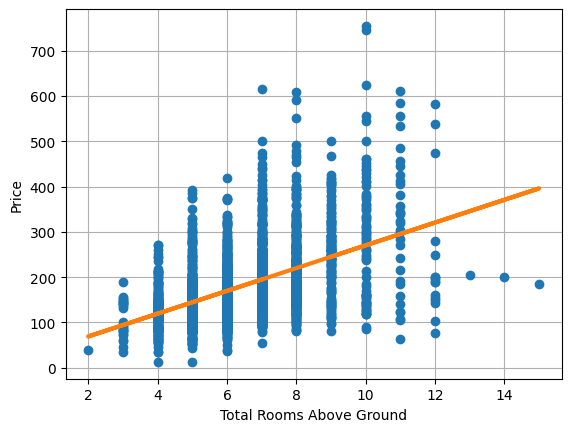

In [9]:
# plot the data
plt.plot(x,y,'o')
plt.plot(x,yp,'-', linewidth=3)
plt.xlabel('Total Rooms Above Ground')
plt.ylabel('Price')
plt.grid(True)

Comparing L2 loss for each predictor with the response vector `y` to identify the best predictor.

In [10]:
#create table where rows are headers, w/ 2nd col of 0s for loss eventually
headers = np.array(df.columns)
LossTable = np.column_stack((headers,np.zeros(len(headers))))
#slice last row because we don't want to compare sale price with itself
LossTable = LossTable[:len(headers)-1,:]

y = np.array(df['SalePrice']) #putting here as well even though defined above for code clarity
#iterate through DB cols except price
for i in range(0,len(headers)-1):
    #convert col to array
    colData = df[headers[i]]
    
    #fitLinear(array, y)
    beta0, beta1, loss = fit_linear(colData,y)
    
    #add loss to col in 2nd table
    LossTable[i,1] = float(loss)
    
#print table
print(LossTable)

#ID min squared loss and print associated attribute and squared loss value
minIndex = np.argmin(LossTable[:,1])
bestPredictor = LossTable[minIndex,0]
print('Best Predictor is {0} w/ Squared Loss = {1:10.2f}'.format(bestPredictor,LossTable[minIndex,1]))

[['Lot Area' 17364460.63312967]
 ['Year Built' 12863461.655125076]
 ['Bsmt Unf SF' 18057516.73699242]
 ['Total Bsmt SF' 11213442.89151707]
 ['1st Flr SF' 11468224.289430445]
 ['2nd Flr SF' 17336169.134594798]
 ['Gr Liv Area' 9354907.186041113]
 ['Full Bath' 13128075.066216197]
 ['Half Bath' 17173638.723055847]
 ['Bedroom AbvGr' 18305394.574674852]
 ['TotRms AbvGrd' 14103614.623574091]
 ['Fireplaces' 14482877.126605589]
 ['Garage Cars' 10845937.086936329]
 ['Garage Area' 11025955.19406088]]
Best Predictor is Gr Liv Area w/ Squared Loss = 9354907.19


Taking a brute force approach to finding optimal beta vals for L2 loss and comparing to L2 loss obtained from closed form solution.

In [11]:
# brute force approach
def fit_approx(x,y):

    #create arrays w/ B1 and B0 options
    beta0Range = np.arange(-50, 50, .1)
    beta1Range = np.arange(-1,1,.005) 
    
    #initialize min to infinity and beta1 and beta0 to 0
    min_loss = np.inf
    beta0, beta1 = 0,0
    
    for currBeta0 in beta0Range:
        for currBeta1 in beta1Range:
            yhat = currBeta0 + currBeta1*x
            currLoss = np.sum((y-yhat)**2)
            if currLoss < min_loss:
                min_loss = currLoss
                beta0 = currBeta0
                beta1 = currBeta1

    return beta0, beta1, min_loss

In [12]:
# fitting the brute force model and comparing to closed form solution

fit approx beta0 = 15.8000
fit approx beta1 = 0.1100
fit approx loss = 9357057.69
fit linear beta0 = 13.2896
fit linear beta1 = 0.1117
fit linear loss = 9354907.19


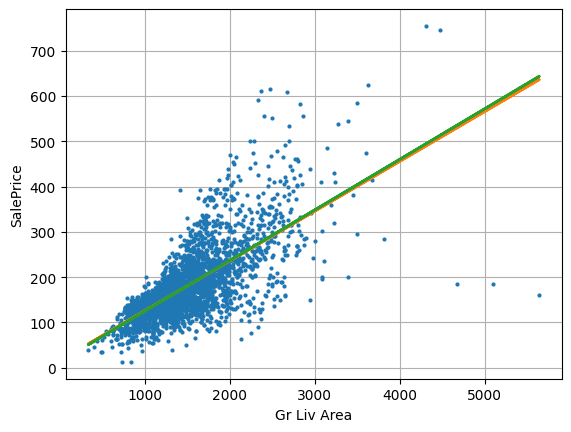

In [13]:
y = np.array(df['SalePrice'])
x = np.array(df['Gr Liv Area'])
approxBeta0, approxBeta1, approxLoss = fit_approx(x,y)
linearBeta0, linearBeta1, linearLoss = fit_linear(x,y)

print('fit approx beta0 = {:4.4f}'.format(approxBeta0))
print('fit approx beta1 = {:4.4f}'.format(approxBeta1))
print('fit approx loss = {:10.2f}'.format(approxLoss))

print('fit linear beta0 = {:4.4f}'.format(linearBeta0))
print('fit linear beta1 = {:4.4f}'.format(linearBeta1))
print('fit linear loss = {:10.2f}'.format(linearLoss))

yApprox = approxBeta0 + approxBeta1*x
yLinear = linearBeta0 + linearBeta1*x

plt.plot(x,y,'o', markersize=2)
plt.plot(x,yApprox,'-', linewidth=2)
plt.plot(x,yLinear,'-', linewidth=2)
plt.xlabel('Gr Liv Area')
plt.ylabel('SalePrice')
plt.grid(True)

Using brute force approach on L1 and Linfinity loss as well, since there is no closed form solution for these loss functions. Comparing the brute force solutions for each loss function

In [14]:
def fit_approx_l1(x,y):

    # TODO complete the following code
    #create arrays w/ B1 and B0 options
    beta0Range = np.arange(-50, 50, .1)
    beta1Range = np.arange(-1,1,.005) 
    
    #initialize min to infinity and beta1 and beta0 to 0
    min_loss = np.inf
    beta0, beta1 = 0,0
    
    for currBeta0 in beta0Range:
        for currBeta1 in beta1Range:
            yhat = currBeta0 + currBeta1*x
            currLoss = np.sum(np.abs(y-yhat))
            if currLoss < min_loss:
                min_loss = currLoss
                beta0 = currBeta0
                beta1 = currBeta1

    return beta0, beta1, min_loss

In [15]:
def fit_approx_max(x,y):
     #create arrays w/ B1 and B0 options
    beta0Range = np.arange(-50, 50, .1)
    beta1Range = np.arange(-1,1,.005) 
    
    #initialize min to infinity and beta1 and beta0 to 0
    min_loss = np.inf
    beta0, beta1 = 0,0
    
    for currBeta0 in beta0Range:
        for currBeta1 in beta1Range:
            yhat = currBeta0 + currBeta1*x
            currLoss = np.max(np.abs(y-yhat))
            if currLoss < min_loss:
                min_loss = currLoss
                beta0 = currBeta0
                beta1 = currBeta1

    return beta0, beta1, min_loss

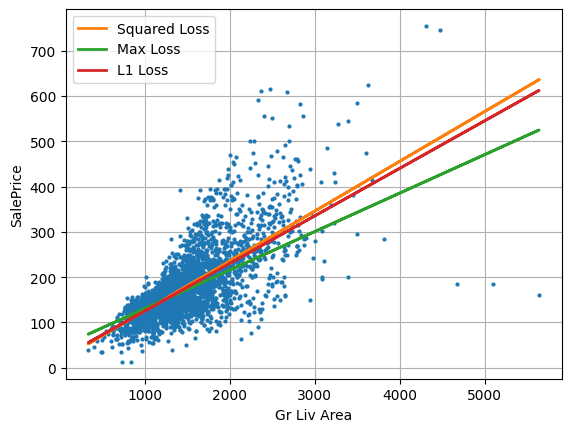

In [16]:
y = np.array(df['SalePrice'])
x = np.array(df['Gr Liv Area'])

lSqBeta0, lSqBeta1, lSqLoss = fit_approx(x,y)
l1Beta0, l1Beta1, l1Loss = fit_approx_l1(x,y)
maxBeta0, maxBeta1, maxLoss = fit_approx_max(x,y)

ySq = lSqBeta0 + lSqBeta1*x
yL1 = l1Beta0 + l1Beta1*x
yLmax = maxBeta0 + maxBeta1*x

plt.plot(x,y,'o', markersize=2)
plt.plot(x,ySq,'-', linewidth=2, label = 'Squared Loss')
plt.plot(x,yLmax,'-', linewidth=2, label = 'Max Loss')
plt.plot(x,yL1,'-', linewidth=2, label = 'L1 Loss')
plt.xlabel('Gr Liv Area')
plt.ylabel('SalePrice')
plt.grid(True)
plt.legend()

Testing brute force models using `Lot Area` as the predictor variable, which better visualizes the differences in loss functions.

fit linear beta0 = 153.3739
fit linear beta1 = 0.0027
fit linear loss = 17364460.63
L sq beta 0 = 153.4000
L sq beta1 = 0.0027
L sq loss = 17364461.58
L1 beta0 = 120.7000
L1 beta1 = 0.0042
L1 loss =  156600.39
Max beta0 = 358.8000
Max beta1 = 0.0014
Max loss =     366.12


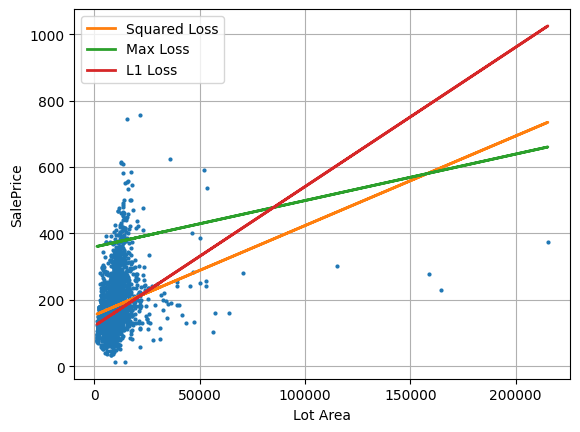

In [17]:
y = np.array(df['SalePrice'])
x = np.array(df['Lot Area'])

#define tweaked min loss functions to change beta ranges 
def fit_approx2(x,y):

    #create arrays w/ B1 and B0 options
    beta0Range = np.arange(0, 200, .1)
    beta1Range = np.arange(0,.005,.0001) 
    
    #initialize min to infinity and beta1 and beta0 to 0
    min_loss = np.inf
    beta0, beta1 = 0,0
    
    for currBeta0 in beta0Range:
        for currBeta1 in beta1Range:
            yhat = currBeta0 + currBeta1*x
            currLoss = np.sum((y-yhat)**2)
            if currLoss < min_loss:
                min_loss = currLoss
                beta0 = currBeta0
                beta1 = currBeta1

    return beta0, beta1, min_loss

def fit_approx_l1_2(x,y):

    #create arrays w/ B1 and B0 options
    beta0Range = np.arange(0,200, .1)
    beta1Range = np.arange(0,.005,.0001) 
    
    #initialize min to infinity and beta1 and beta0 to 0
    min_loss = np.inf
    beta0, beta1 = 0,0
    
    for currBeta0 in beta0Range:
        for currBeta1 in beta1Range:
            yhat = currBeta0 + currBeta1*x
            currLoss = np.sum(np.abs(y-yhat))
            if currLoss < min_loss:
                min_loss = currLoss
                beta0 = currBeta0
                beta1 = currBeta1

    return beta0, beta1, min_loss

def fit_approx_max2(x,y):
    
    #create arrays w/ B1 and B0 options
    beta0Range = np.arange(250,400, .1)
    beta1Range = np.arange(0,.005,.0001) 
       
    #initialize min to infinity and beta1 and beta0 to 0
    min_loss = np.inf
    beta0, beta1 = 0,0
    
    for currBeta0 in beta0Range:
        for currBeta1 in beta1Range:
            yhat = currBeta0 + currBeta1*x
            currLoss = np.max(np.abs(y-yhat))
            if currLoss < min_loss:
                min_loss = currLoss
                beta0 = currBeta0
                beta1 = currBeta1

    return beta0, beta1, min_loss

#run on linear fit function to get best values to ID what to set brute force beta ranges to
beta0, beta1, min_loss = fit_linear(x,y)
print('fit linear beta0 = {:4.4f}'.format(beta0))
print('fit linear beta1 = {:4.4f}'.format(beta1))
print('fit linear loss = {:10.2f}'.format(min_loss))

#run new functions for lot area attribute as indep. var
lSqBeta0, lSqBeta1, lSqLoss = fit_approx2(x,y)
l1Beta0, l1Beta1, l1Loss = fit_approx_l1_2(x,y)
maxBeta0, maxBeta1, maxLoss = fit_approx_max2(x,y)

print('L sq beta 0 = {:4.4f}'.format(lSqBeta0))
print('L sq beta1 = {:4.4f}'.format(lSqBeta1))
print('L sq loss = {:10.2f}'.format(lSqLoss))
print('L1 beta0 = {:4.4f}'.format(l1Beta0))
print('L1 beta1 = {:4.4f}'.format(l1Beta1))
print('L1 loss = {:10.2f}'.format(l1Loss))
print('Max beta0 = {:4.4f}'.format(maxBeta0))
print('Max beta1 = {:4.4f}'.format(maxBeta1))
print('Max loss = {:10.2f}'.format(maxLoss))

ySq = lSqBeta0 + lSqBeta1*x
yL1 = l1Beta0 + l1Beta1*x
yLmax = maxBeta0 + maxBeta1*x

plt.plot(x,y,'o', markersize=2)
plt.plot(x,ySq,'-', linewidth=2, label = 'Squared Loss')
plt.plot(x,yLmax,'-', linewidth=2, label = 'Max Loss')
plt.plot(x,yL1,'-', linewidth=2, label = 'L1 Loss')
plt.xlabel('Lot Area')
plt.ylabel('SalePrice')
plt.grid(True)
plt.legend()